# 🐾 PawMI - Pipeline Completo de Predicción de Enfermedades
## Análisis Avanzado con Features Extendidas

**Dataset:** `diagnosticos_sinteticos3_0.csv` (~10,000 registros)

**Nuevas features incluidas:**
- `causa`: Tipo de causa (viral, bacteriana, parasitaria, etc.)
- `cronica`: Si la enfermedad es crónica (True/False)
- `estacional`: Si tiene patrón estacional (True/False)
- `prevalencia_estimada`: Prevalencia en la población
- `pronostico`: Pronóstico de la enfermedad
- `fiebre_objetiva`: Indicador objetivo de fiebre
- `taquicardia`: Indicador de taquicardia
- `vacunacion_al_dia`: Estado de vacunación

**Objetivo:** Alcanzar ≥90% accuracy en testing


## 📚 1. Importar Librerías

In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print('Librerías importadas correctamente')

Librerías importadas correctamente


## 📂 2. Cargar Dataset Sintético

In [2]:
# Cargar dataset de diagnosticos sinteticos mejorado
data_path = Path('../data/raw')
df_raw = pd.read_csv(data_path / 'diagnosticos_sinteticos3_0.csv')

print('Dataset cargado exitosamente')
print(f'\nDimensiones: {df_raw.shape[0]:,} filas x {df_raw.shape[1]} columnas')

# Verificar especies en el dataset
print(f'\nEspecies en el dataset:')
print(df_raw['especie'].value_counts())

print(f'\nColumnas principales del dataset:')
print(f'   - Demograficas: especie, raza, tamaño, edad_anios, etapa_vida, peso_kg')
print(f'   - Signos vitales: temperatura_c, fc_bpm, fr_rpm, bcs_1_9')
print(f'   - Sintomas binarios: vomitos, diarrea, fiebre, letargo, tos, etc.')
print(f'   - Target: enfermedad')

print(f'\nEnfermedades unicas: {df_raw["enfermedad"].nunique()}')
print(f'\nPrimeras 3 filas:')
df_raw.head(3)

Dataset cargado exitosamente

Dimensiones: 10,000 filas x 51 columnas

Especies en el dataset:
especie
Perro    5992
Gato     4008
Name: count, dtype: int64

Columnas principales del dataset:
   - Demograficas: especie, raza, tamaño, edad_anios, etapa_vida, peso_kg
   - Signos vitales: temperatura_c, fc_bpm, fr_rpm, bcs_1_9
   - Sintomas binarios: vomitos, diarrea, fiebre, letargo, tos, etc.
   - Target: enfermedad

Enfermedades unicas: 36

Primeras 3 filas:


,id,especie,raza,tamaño,edad_anios,etapa_vida,peso_kg,bcs_1_9,temperatura_c,fc_bpm,...,taquipnea,causa,cronica,estacional,prevalencia_estimada,pronostico,recomendaciones,vacunacion_al_dia,fuente,timestamp_generacion
0,PET_00001,Perro,Mestizo,pequeño,0.4,cachorro/gatito,9.2,6,38.5,96,...,0,viral,False,False,0.14,reservado,"Aislar, soporte intensivo con fluidoterapia y ...",False,WSAVA,2025-11-01T07:00:00
1,PET_00002,Perro,Chihuahua,pequeño,0.3,cachorro/gatito,2.4,6,38.5,123,...,0,viral,False,False,0.13,reservado,"Aislar, soporte intensivo con fluidoterapia y ...",False,AVMA,2025-11-01T07:00:00
2,PET_00003,Perro,Pastor Alemán,grande,0.9,cachorro/gatito,20.7,5,39.6,88,...,0,viral,False,False,0.13,reservado,"Aislar, soporte intensivo con fluidoterapia y ...",False,WSAVA,2025-11-01T07:00:00


## 🧹 3. Limpieza y Preprocesamiento de Datos

In [3]:
# El usuario hace una copia para trabajar
df = df_raw.copy()

print('Iniciando preprocesamiento de datos...\n')

# 1. Verificar estructura del dataset
print('1. ESTRUCTURA DEL DATASET:')
print(f'   Columnas totales: {df.shape[1]}')
print(f'   Registros: {df.shape[0]:,}')

# 2. Mapear columnas a nombres estandar para ML
print('\n2. Mapeando columnas a formato ML estandar...')

# Crear dataset en formato estandar
df_processed = pd.DataFrame()

# Variables demograficas
df_processed['Animal_Type'] = df['especie']
df_processed['Breed'] = df['raza']
df_processed['Size'] = df['tamaño']  # Nota: con ñ en el CSV original
df_processed['Age'] = df['edad_anios']
df_processed['Life_Stage'] = df['etapa_vida']

# Variables fisiologicas
df_processed['Weight'] = df['peso_kg']
df_processed['BCS'] = df['bcs_1_9']  # Body Condition Score
df_processed['Body_Temperature'] = df['temperatura_c']
df_processed['Heart_Rate'] = df['fc_bpm']  # Frecuencia cardiaca
df_processed['Respiratory_Rate'] = df['fr_rpm']  # Frecuencia respiratoria

# Variables binarias de sintomas
symptom_cols = ['vomitos', 'diarrea', 'diarrea_hemorragica', 'fiebre', 'letargo', 
                'deshidratacion', 'tos', 'disnea', 'estornudos', 'secrecion_nasal',
                'secrecion_ocular', 'ulceras_orales', 'prurito', 'alopecia', 'otitis',
                'dolor_abdominal', 'ictericia', 'hematuria', 'disuria', 'cojera',
                'rigidez', 'dolor_articular', 'convulsiones', 'signos_neurologicos',
                'hipersalivacion', 'soplo_cardiaco', 'taquipnea']

for col in symptom_cols:
    if col in df.columns:
        df_processed[col.capitalize()] = df[col]

print(f'   ✓ Síntomas binarios mapeados ({len(symptom_cols)})')

# ===== NUEVAS FEATURES EN DATASET 3.0 =====
# Indicadores clínicos objetivos
if 'fiebre_objetiva' in df.columns:
    df_processed['Fever_Objective'] = df['fiebre_objetiva']
    print('   ✓ Fiebre objetiva mapeada')

if 'taquicardia' in df.columns:
    df_processed['Tachycardia'] = df['taquicardia']
    print('   ✓ Taquicardia mapeada')

# Metadata de enfermedad (NUEVAS en Dataset 3.0)
if 'causa' in df.columns:
    df_processed['Disease_Cause'] = df['causa']
    print('   ✓ Causa de enfermedad mapeada')

if 'cronica' in df.columns:
    df_processed['Is_Chronic'] = df['cronica'].astype(int)
    print('   ✓ Indicador de cronicidad mapeado')

if 'estacional' in df.columns:
    df_processed['Is_Seasonal'] = df['estacional'].astype(int)
    print('   ✓ Indicador estacional mapeado')

if 'prevalencia_estimada' in df.columns:
    df_processed['Prevalence'] = df['prevalencia_estimada']
    print('   ✓ Prevalencia mapeada')

if 'pronostico' in df.columns:
    df_processed['Prognosis'] = df['pronostico']
    print('   ✓ Pronóstico mapeado')

if 'vacunacion_al_dia' in df.columns:
    df_processed['Vaccination_Updated'] = df['vacunacion_al_dia'].astype(int)
    print('   ✓ Estado de vacunación mapeado')

# Variable objetivo
df_processed['Disease_Prediction'] = df['enfermedad']

print(f'   Columnas mapeadas: {df_processed.shape[1]}')

# 3. Limpiar y validar datos
print('\n3. Limpieza de datos...')

# Verificar valores nulos
null_counts = df_processed.isnull().sum()
if null_counts.sum() == 0:
    print('   ✓ No hay valores nulos')
else:
    print('   Valores nulos encontrados:')
    for col, count in null_counts[null_counts > 0].items():
        print(f'     - {col}: {count}')
    df_processed = df_processed.dropna()
    print(f'   Filas eliminadas: {len(df) - len(df_processed)}')

# 4. Verificar duplicados
duplicates = df_processed.duplicated().sum()
if duplicates > 0:
    print(f'\n4. {duplicates} duplicados encontrados (se mantienen)')
else:
    print(f'\n4. ✓ No hay duplicados')

# 5. Resumen final
print(f'\n✅ Preprocesamiento completado')
print(f'   Dataset final: {df_processed.shape}')
print(f'   - Especies: {df_processed["Animal_Type"].nunique()}')
print(f'   - Razas: {df_processed["Breed"].nunique()}')
print(f'   - Enfermedades: {df_processed["Disease_Prediction"].nunique()}')
print(f'   - Variables demográficas: 5')
print(f'   - Variables fisiológicas: 5')
print(f'   - Variables de síntomas: {len(symptom_cols)}')

# Contar nuevas features si existen
new_features = ['Fever_Objective', 'Tachycardia', 'Disease_Cause', 'Is_Chronic', 
                'Is_Seasonal', 'Prevalence', 'Prognosis', 'Vaccination_Updated']
new_count = sum(1 for f in new_features if f in df_processed.columns)
if new_count > 0:
    print(f'   - Variables NUEVAS Dataset 3.0: {new_count}')

# Asignar al DataFrame principal
df = df_processed.copy()

Iniciando preprocesamiento de datos...

1. ESTRUCTURA DEL DATASET:
   Columnas totales: 51
   Registros: 10,000

2. Mapeando columnas a formato ML estandar...
   ✓ Síntomas binarios mapeados (27)
   ✓ Fiebre objetiva mapeada
   ✓ Taquicardia mapeada
   ✓ Causa de enfermedad mapeada
   ✓ Indicador de cronicidad mapeado
   ✓ Indicador estacional mapeado
   ✓ Prevalencia mapeada
   ✓ Pronóstico mapeado
   ✓ Estado de vacunación mapeado
   Columnas mapeadas: 46

3. Limpieza de datos...
   ✓ No hay valores nulos

4. ✓ No hay duplicados

✅ Preprocesamiento completado
   Dataset final: (10000, 46)
   - Especies: 2
   - Razas: 34
   - Enfermedades: 36
   - Variables demográficas: 5
   - Variables fisiológicas: 5
   - Variables de síntomas: 27
   - Variables NUEVAS Dataset 3.0: 8


### 🔍 3.1. Deteccion y Tratamiento de Outliers

Eliminar outliers en variables fisiologicas para reducir ruido y mejorar generalizacion del modelo

In [4]:
# El usuario detecta y trata outliers usando el metodo IQR (Interquartile Range)
from scipy.stats import zscore

print('DETECCION Y TRATAMIENTO DE OUTLIERS')
print('='*70)

# Variables numericas continuas que pueden tener outliers
numeric_vars = ['Age', 'Weight', 'Body_Temperature', 'Heart_Rate', 'Respiratory_Rate', 'BCS']

print('\n1. DETECCION DE OUTLIERS (Metodo IQR):')
print(f'   Variables analizadas: {len(numeric_vars)}')

outliers_info = {}
df_clean = df.copy()

for var in numeric_vars:
    # Calcular Q1, Q3 e IQR
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    
    # Definir limites
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Detectar outliers
    outliers_mask = (df[var] < lower_bound) | (df[var] > upper_bound)
    n_outliers = outliers_mask.sum()
    
    outliers_info[var] = {
        'n_outliers': n_outliers,
        'pct': (n_outliers / len(df)) * 100,
        'lower': lower_bound,
        'upper': upper_bound
    }
    
    print(f'\n   {var}:')
    print(f'     - Outliers detectados: {n_outliers} ({outliers_info[var]["pct"]:.2f}%)')
    print(f'     - Rango aceptable: [{lower_bound:.2f}, {upper_bound:.2f}]')

print('\n2. ELIMINACION DE OUTLIERS:')
print(f'   Registros originales: {len(df):,}')

# Eliminar filas con outliers en cualquier variable
for var in numeric_vars:
    Q1 = df_clean[var].quantile(0.25)
    Q3 = df_clean[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_clean = df_clean[(df_clean[var] >= lower_bound) & (df_clean[var] <= upper_bound)]

removed = len(df) - len(df_clean)
print(f'   Registros eliminados: {removed:,} ({(removed/len(df))*100:.2f}%)')
print(f'   Registros finales: {len(df_clean):,}')

# Verificar distribucion por enfermedad despues de limpieza
print(f'\n3. VERIFICACION POST-LIMPIEZA:')
print(f'   Enfermedades originales: {df["Disease_Prediction"].nunique()}')
print(f'   Enfermedades despues limpieza: {df_clean["Disease_Prediction"].nunique()}')

# Actualizar DataFrame principal
df = df_clean.copy()

print(f'\nDataset limpio y listo para analisis')

DETECCION Y TRATAMIENTO DE OUTLIERS

1. DETECCION DE OUTLIERS (Metodo IQR):
   Variables analizadas: 6

   Age:
     - Outliers detectados: 0 (0.00%)
     - Rango aceptable: [-6.40, 20.80]

   Weight:
     - Outliers detectados: 222 (2.22%)
     - Rango aceptable: [-23.79, 51.11]

   Body_Temperature:
     - Outliers detectados: 632 (6.32%)
     - Rango aceptable: [37.90, 39.50]

   Heart_Rate:
     - Outliers detectados: 0 (0.00%)
     - Rango aceptable: [21.50, 241.50]

   Respiratory_Rate:
     - Outliers detectados: 130 (1.30%)
     - Rango aceptable: [9.50, 37.50]

   BCS:
     - Outliers detectados: 0 (0.00%)
     - Rango aceptable: [1.00, 9.00]

2. ELIMINACION DE OUTLIERS:
   Registros originales: 10,000
   Registros eliminados: 967 (9.67%)
   Registros finales: 9,033

3. VERIFICACION POST-LIMPIEZA:
   Enfermedades originales: 36
   Enfermedades despues limpieza: 36

Dataset limpio y listo para analisis


## 📊 4. Análisis Exploratorio de Datos (EDA)

Siguiendo la metodología de IA-Course-UdB

In [5]:
print('ANALISIS EXPLORATORIO DE DATOS')

# Informacion general
print('\n1. INFORMACION GENERAL:')
print(f'Total de registros: {len(df):,}')
print(f'Total de columnas: {df.shape[1]}')
print(f'Memoria usada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')

# Distribucion de especies
print('\n2. DISTRIBUCION DE ESPECIES:')
species_dist = df['Animal_Type'].value_counts()
for species, count in species_dist.items():
    pct = (count / len(df)) * 100
    print(f'   - {species}: {count:,} ({pct:.1f}%)')

# Distribucion de enfermedades
print('\n3. DISTRIBUCION DE ENFERMEDADES:')
disease_counts = df['Disease_Prediction'].value_counts()
print(f'Total de enfermedades unicas: {len(disease_counts)}')
print(f'\nTop 15 enfermedades mas comunes:')
for i, (disease, count) in enumerate(disease_counts.head(15).items(), 1):
    pct = (count / len(df)) * 100
    print(f'   {i:2d}. {disease:45s} {count:4d} ({pct:5.2f}%)')

# Estadisticas de variables numericas
print('\n4. ESTADISTICAS DE VARIABLES NUMERICAS:')
numeric_cols = ['Age', 'Weight', 'Body_Temperature', 'Heart_Rate', 'Respiratory_Rate', 'BCS']
print(df[numeric_cols].describe().round(2))

# Prevalencia de sintomas
print('\n5. PREVALENCIA DE SINTOMAS (Top 10):')
symptom_cols = [col for col in df.columns if col not in ['Animal_Type', 'Breed', 'Size', 'Age', 'Life_Stage',
                                                           'Weight', 'BCS', 'Body_Temperature', 'Heart_Rate',
                                                           'Respiratory_Rate', 'Disease_Prediction']]
symptom_prevalence = {col: df[col].mean() * 100 for col in symptom_cols if df[col].dtype in ['int64', 'float64']}
symptom_prevalence_sorted = sorted(symptom_prevalence.items(), key=lambda x: x[1], reverse=True)[:10]

for symptom, prevalence in symptom_prevalence_sorted:
    print(f'   - {symptom}: {prevalence:.1f}%')

ANALISIS EXPLORATORIO DE DATOS

1. INFORMACION GENERAL:
Total de registros: 9,033
Total de columnas: 46
Memoria usada: 7.25 MB

2. DISTRIBUCION DE ESPECIES:
   - Perro: 5,377 (59.5%)
   - Gato: 3,656 (40.5%)

3. DISTRIBUCION DE ENFERMEDADES:
Total de enfermedades unicas: 36

Top 15 enfermedades mas comunes:
    1. Diabetes mellitus (gato)                       290 ( 3.21%)
    2. Enfermedad del tracto urinario inferior felino (FLUTD)  289 ( 3.20%)
    3. Hipotiroidismo                                 289 ( 3.20%)
    4. Enfermedad dental/estomatitis felina           288 ( 3.19%)
    5. Virus de la inmunodeficiencia felina (FIV)     288 ( 3.19%)
    6. Obesidad (gato)                                287 ( 3.18%)
    7. Hipertiroidismo (gato)                         287 ( 3.18%)
    8. Neoplasia (gato)                               285 ( 3.16%)
    9. Síndrome braquicefálico                        285 ( 3.16%)
   10. Diabetes mellitus (perro)                      284 ( 3.14%)
   11. Sarna

### 📈 Visualizaciones del EDA

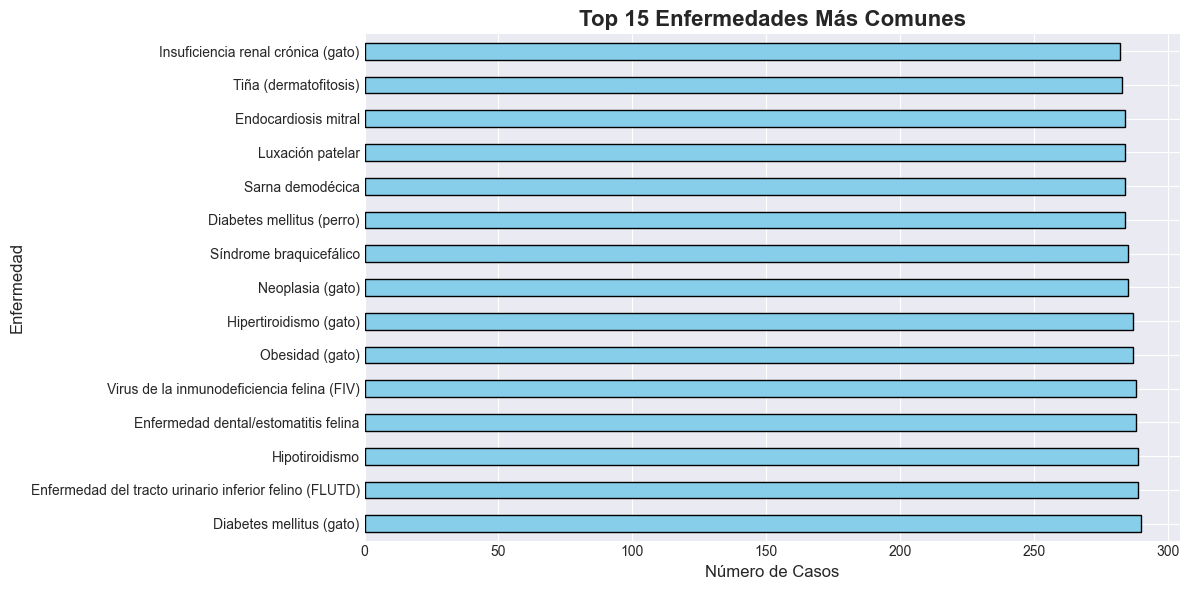

In [6]:
# Gráfico 1: Distribución de enfermedades (Top 15)
plt.figure(figsize=(12, 6))
disease_counts.head(15).plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Top 15 Enfermedades Más Comunes', fontsize=16, fontweight='bold')
plt.xlabel('Número de Casos', fontsize=12)
plt.ylabel('Enfermedad', fontsize=12)
plt.tight_layout()
plt.show()

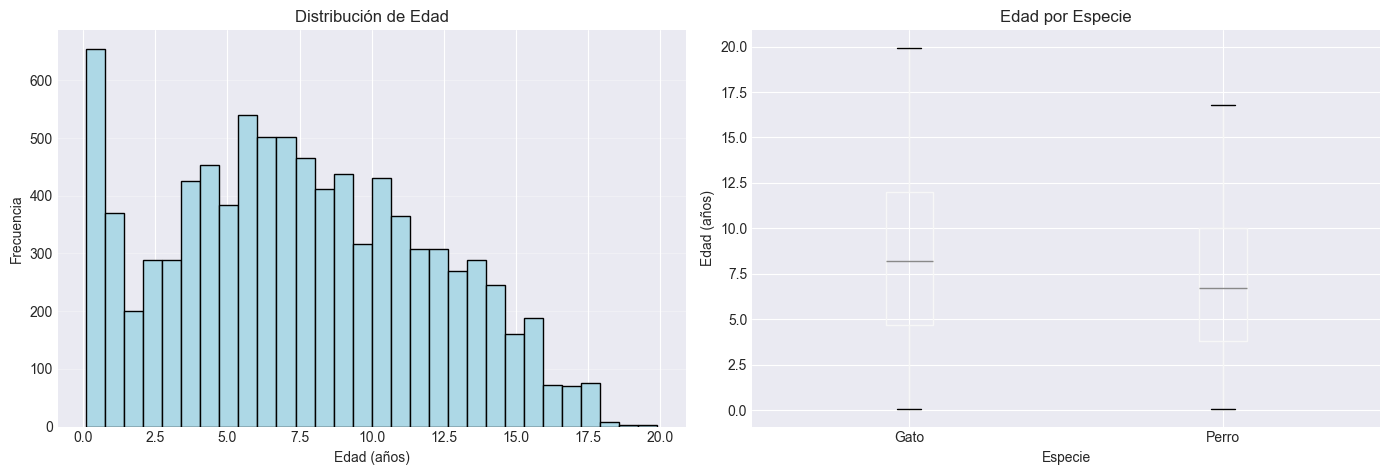

In [7]:
# Gráfico 2: Distribución de edad
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Análisis de Edad', fontsize=16, fontweight='bold')

# Histograma de edad
df['Age'].hist(bins=30, ax=axes[0], color='lightblue', edgecolor='black')
axes[0].set_title('Distribución de Edad')
axes[0].set_xlabel('Edad (años)')
axes[0].set_ylabel('Frecuencia')
axes[0].grid(axis='y', alpha=0.3)

# Boxplot de edad por especie
df.boxplot(column='Age', by='Animal_Type', ax=axes[1])
axes[1].set_title('Edad por Especie')
axes[1].set_xlabel('Especie')
axes[1].set_ylabel('Edad (años)')
plt.suptitle('')  # Quitar título automático

plt.tight_layout()
plt.show()

Análisis: Enfermedades por Rango de Edad


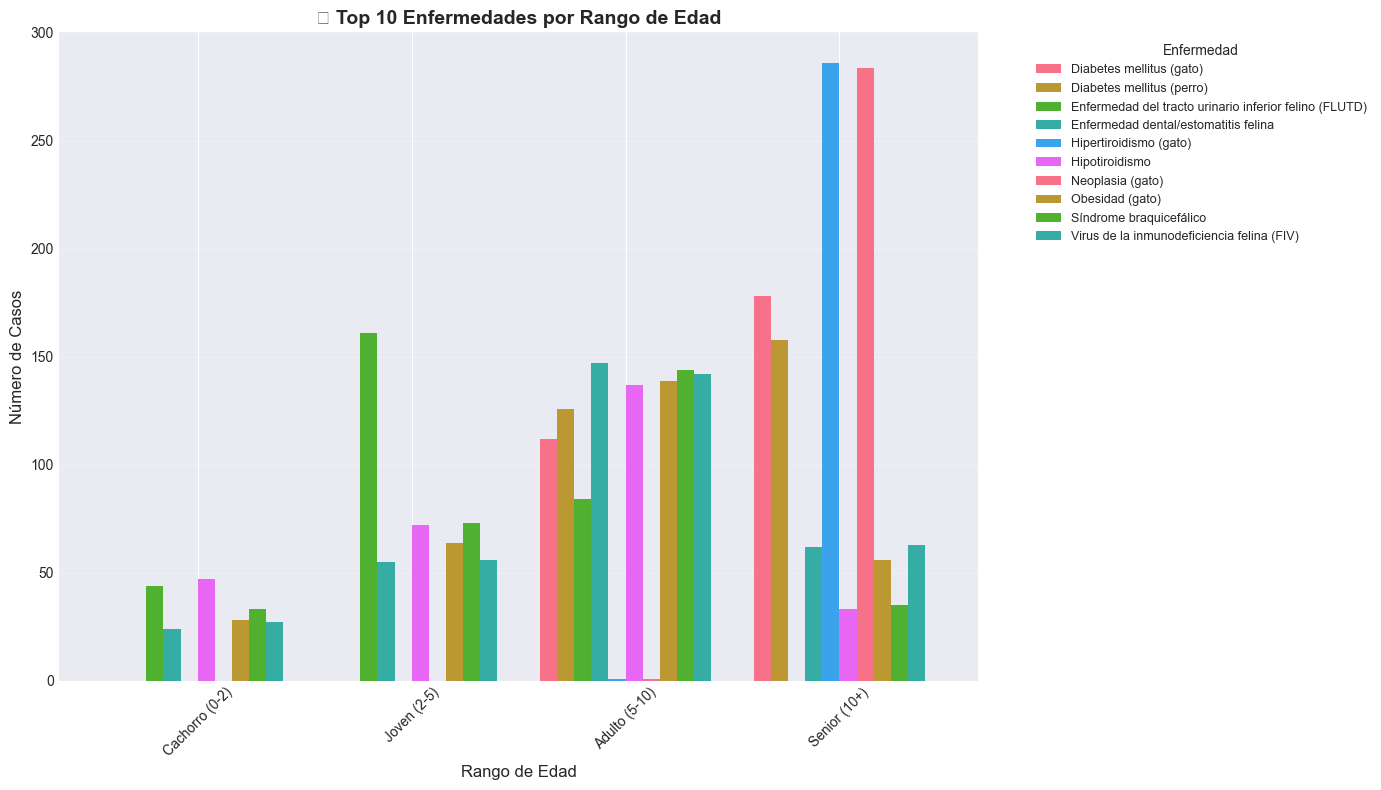

In [8]:
# Gráfico 3: Relación Edad vs Enfermedad
# Analizar enfermedades más comunes por rango de edad

print('Análisis: Enfermedades por Rango de Edad')

# Crear rangos de edad
df['Rango_Edad'] = pd.cut(df['Age'], bins=[0, 2, 5, 10, 20], 
                           labels=['Cachorro (0-2)', 'Joven (2-5)', 'Adulto (5-10)', 'Senior (10+)'])

# Top 10 enfermedades
top_10_diseases = df['Disease_Prediction'].value_counts().head(10).index

# Contar ocurrencias por rango de edad
age_disease_counts = df[df['Disease_Prediction'].isin(top_10_diseases)].groupby(
    ['Rango_Edad', 'Disease_Prediction']).size().unstack(fill_value=0)

# Visualizar
fig, ax = plt.subplots(figsize=(14, 8))
age_disease_counts.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('🔬 Top 10 Enfermedades por Rango de Edad', fontsize=14, fontweight='bold')
ax.set_xlabel('Rango de Edad', fontsize=12)
ax.set_ylabel('Número de Casos', fontsize=12)
ax.legend(title='Enfermedad', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Eliminar columna temporal
df = df.drop('Rango_Edad', axis=1)

### 🎯 Análisis de Dispersión: ¿Qué Features Aportan Valor?

Análisis de relación entre edad y enfermedades para identificar patrones discriminativos.

ANALISIS DE DISPERSION DE FEATURES

Dataset completo con 45 features disponibles
Analizando la relacion entre Edad y Enfermedad...



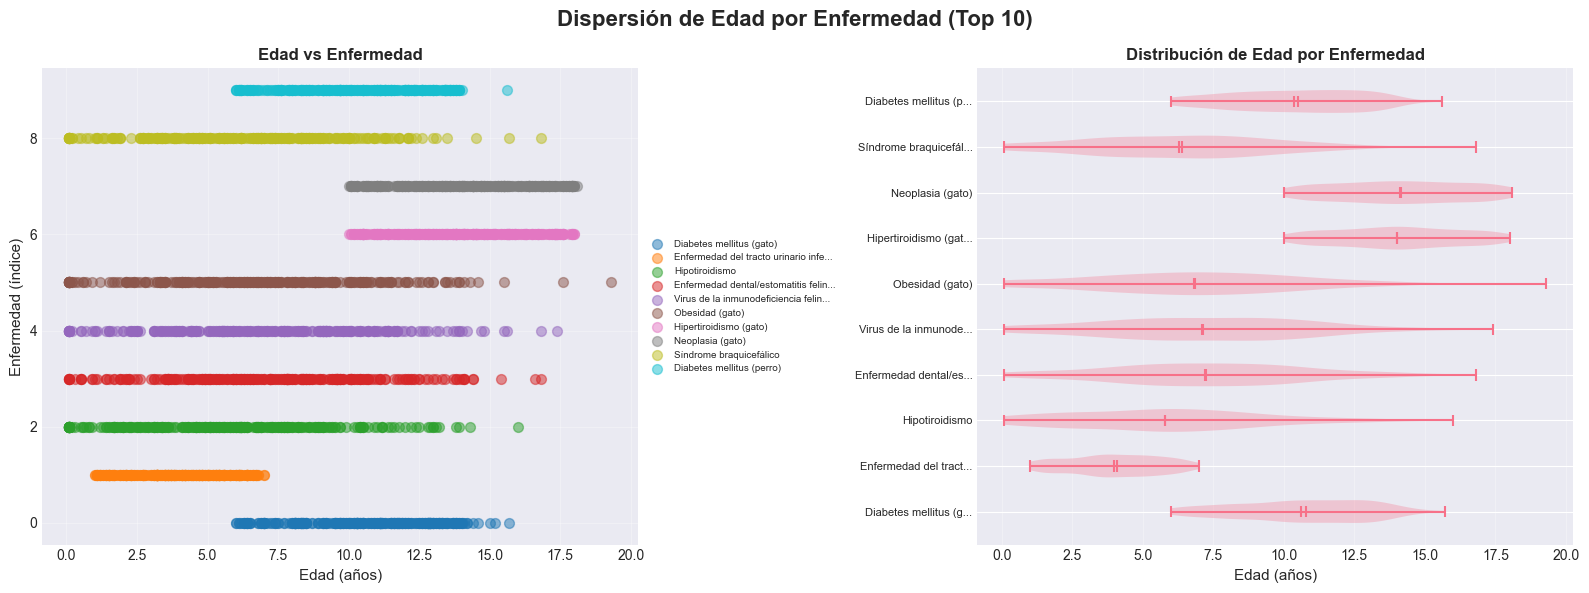


Interpretación:
   Separación clara = Enfermedades específicas de ciertas edades → Age es útil
   Alta superposición = Age tiene poco poder discriminativo
   Violin plot muestra si cada enfermedad tiene un rango de edad característico


In [9]:
# Analisis de dispersion con datos disponibles
print('ANALISIS DE DISPERSION DE FEATURES')
print('='*70)
print(f'\nDataset completo con {df.shape[1]-1} features disponibles')
print('Analizando la relacion entre Edad y Enfermedad...\n')

# Tomar las 10 enfermedades más comunes para visualización
top_diseases = df['Disease_Prediction'].value_counts().head(10).index
df_sample = df[df['Disease_Prediction'].isin(top_diseases)].copy()

# Crear visualización: Edad por Enfermedad y Especie
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Dispersión de Edad por Enfermedad (Top 10)', 
             fontsize=16, fontweight='bold')

colors = plt.cm.tab10(range(len(top_diseases)))
disease_color_map = dict(zip(top_diseases, colors))

# Gráfico 1: Scatter plot Edad vs Enfermedad (codificada como número)
ax = axes[0]

# Crear mapeo numérico de enfermedades para visualización
disease_to_num = {disease: i for i, disease in enumerate(top_diseases)}
df_sample['Disease_Num'] = df_sample['Disease_Prediction'].map(disease_to_num)

for disease in top_diseases:
    mask = df_sample['Disease_Prediction'] == disease
    ax.scatter(df_sample[mask]['Age'], 
              df_sample[mask]['Disease_Num'],
              alpha=0.5, s=50,
              color=disease_color_map[disease],
              label=disease[:35] + '...' if len(disease) > 35 else disease)

ax.set_xlabel('Edad (años)', fontsize=11)
ax.set_ylabel('Enfermedad (índice)', fontsize=11)
ax.set_title('Edad vs Enfermedad', fontsize=12, fontweight='bold')
ax.legend(fontsize=7, loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True, alpha=0.3)

# Gráfico 2: Violin plot - Distribución de edad por enfermedad
ax = axes[1]

# Preparar datos para violin plot
plot_data = []
plot_labels = []
for disease in top_diseases:
    ages = df_sample[df_sample['Disease_Prediction'] == disease]['Age'].values
    plot_data.append(ages)
    # Truncar nombre de enfermedad
    short_name = disease[:20] + '...' if len(disease) > 20 else disease
    plot_labels.append(short_name)

parts = ax.violinplot(plot_data, vert=False, showmeans=True, showmedians=True)
ax.set_yticks(range(1, len(top_diseases) + 1))
ax.set_yticklabels(plot_labels, fontsize=8)
ax.set_xlabel('Edad (años)', fontsize=11)
ax.set_title('Distribución de Edad por Enfermedad', fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Limpiar columna temporal
df_sample = df_sample.drop('Disease_Num', axis=1)

print('\nInterpretación:')
print('   Separación clara = Enfermedades específicas de ciertas edades → Age es útil')
print('   Alta superposición = Age tiene poco poder discriminativo')
print('   Violin plot muestra si cada enfermedad tiene un rango de edad característico')


ANÁLISIS DE ESPECIE (Animal_Type)

Especie         N° Registros    N° Enfermedades        Entropía
----------------------------------------------------------------------
🟢 Perro         5,377           22                        3.043
🟡 Gato          3,656           15                        2.645

Interpretación:
   🟢 Entropía > 3.0 = Especie tiene distribución diversa de enfermedades (muy útil)
   🟡 Entropía 2-3   = Moderadamente útil
   🔴 Entropía < 2.0 = Poca diversidad (menos útil)


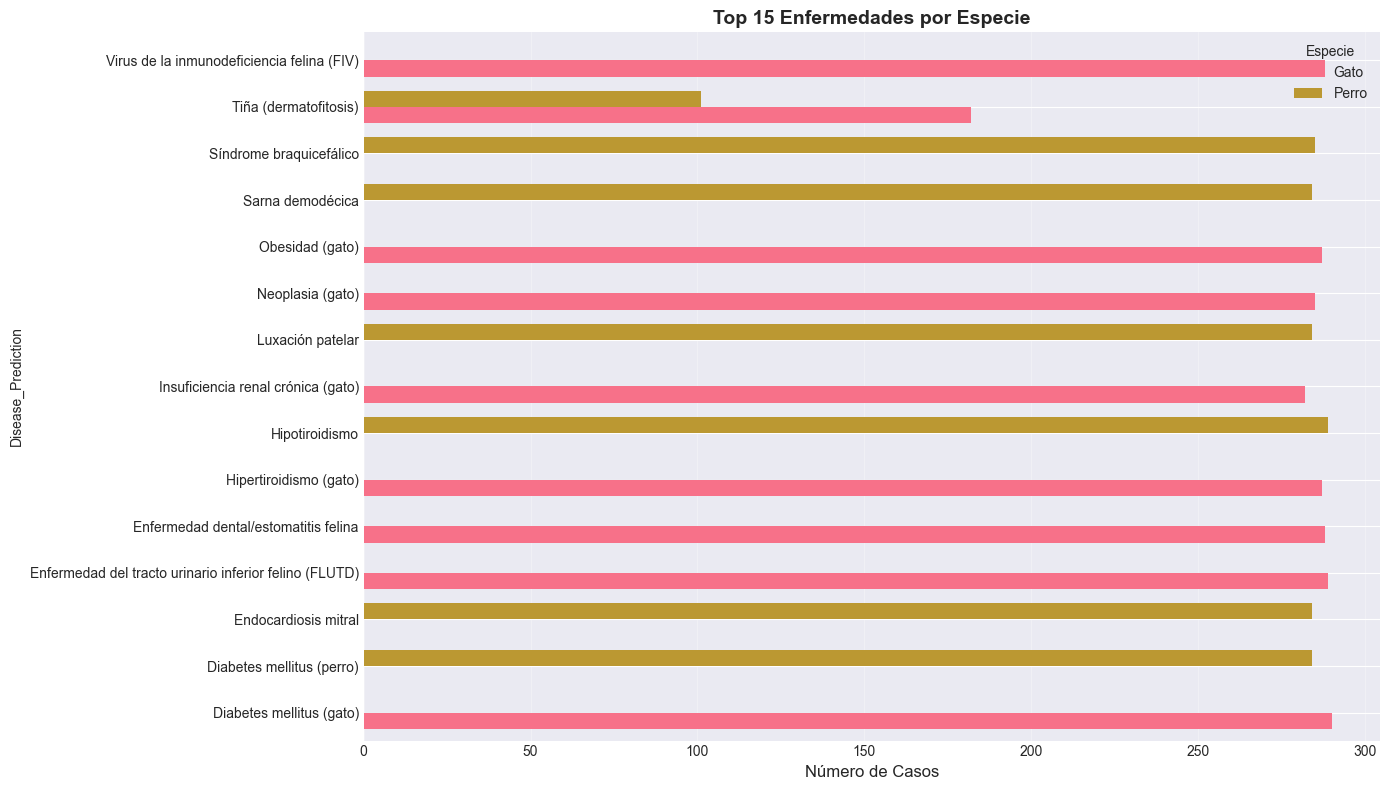



RESUMEN DE FEATURES DISPONIBLES:

FEATURES DISPONIBLES:

DEMOGRAFICAS (4):
   - Animal_Type (Especie): 2 categorias
   - Size (Tamaño): 3 categorias
   - Age (Edad): continua
   - Life_Stage (Etapa de vida): 4 categorias

FISIOLOGICAS (5):
   - Weight (Peso en kg): continua
   - BCS (Body Condition Score): 1-9
   - Body_Temperature (Temperatura en °C): continua
   - Heart_Rate (Frecuencia cardiaca): continua
   - Respiratory_Rate (Frecuencia respiratoria): continua

SINTOMAS BINARIOS (35):
   Vomitos, Diarrea, Fiebre, Letargo, Tos, Disnea, etc.

TOTAL DE FEATURES PARA ML: 44
TARGET: Disease_Prediction (36 enfermedades)

Este dataset es COMPLETO y robusto para entrenamiento de modelos de ML


In [10]:
# Análisis de Animal_Type (Especie)
print('\nANÁLISIS DE ESPECIE (Animal_Type)')
print('='*70)

from scipy.stats import entropy

# Analizar distribución de enfermedades por especie
animal_disease_dist = pd.crosstab(df['Animal_Type'], df['Disease_Prediction'], normalize='index')
animal_entropy = animal_disease_dist.apply(lambda x: entropy(x + 1e-10), axis=1)

print(f'\n{"Especie":<15} {"N° Registros":<15} {"N° Enfermedades":<20} {"Entropía":>10}')
print('-'*70)
for animal in df['Animal_Type'].unique():
    n_records = (df['Animal_Type'] == animal).sum()
    n_diseases = df[df['Animal_Type'] == animal]['Disease_Prediction'].nunique()
    ent = animal_entropy[animal]
    status = '🟢' if ent > 3.0 else '🟡' if ent > 2.0 else '🔴'
    print(f'{status} {animal:<13} {n_records:<15,} {n_diseases:<20} {ent:>10.3f}')

print('\nInterpretación:')
print('   🟢 Entropía > 3.0 = Especie tiene distribución diversa de enfermedades (muy útil)')
print('   🟡 Entropía 2-3   = Moderadamente útil')
print('   🔴 Entropía < 2.0 = Poca diversidad (menos útil)')

# Visualizar top 15 enfermedades por especie
fig, ax = plt.subplots(figsize=(14, 8))

animal_counts = df.groupby(['Animal_Type', 'Disease_Prediction']).size().reset_index(name='count')
top_15_diseases = df['Disease_Prediction'].value_counts().head(15).index
animal_counts_top = animal_counts[animal_counts['Disease_Prediction'].isin(top_15_diseases)]

pivot_data = animal_counts_top.pivot(index='Disease_Prediction', columns='Animal_Type', values='count').fillna(0)
pivot_data.plot(kind='barh', stacked=False, ax=ax, width=0.7)

ax.set_xlabel('Número de Casos', fontsize=12)
ax.set_title('Top 15 Enfermedades por Especie', fontsize=14, fontweight='bold')
ax.legend(title='Especie', fontsize=10)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print('\n\nRESUMEN DE FEATURES DISPONIBLES:')
print('='*70)
print('\nFEATURES DISPONIBLES:')
print(f'\nDEMOGRAFICAS (4):')
print(f'   - Animal_Type (Especie): {df["Animal_Type"].nunique()} categorias')
print(f'   - Size (Tamaño): {df["Size"].nunique()} categorias')
print(f'   - Age (Edad): continua')
print(f'   - Life_Stage (Etapa de vida): {df["Life_Stage"].nunique()} categorias')

print(f'\nFISIOLOGICAS (5):')
print(f'   - Weight (Peso en kg): continua')
print(f'   - BCS (Body Condition Score): 1-9')
print(f'   - Body_Temperature (Temperatura en °C): continua')
print(f'   - Heart_Rate (Frecuencia cardiaca): continua')
print(f'   - Respiratory_Rate (Frecuencia respiratoria): continua')

symptom_count = len([col for col in df.columns if col not in ['Animal_Type', 'Breed', 'Size', 'Age', 'Life_Stage',
                                                                'Weight', 'BCS', 'Body_Temperature', 'Heart_Rate',
                                                                'Respiratory_Rate', 'Disease_Prediction']])
print(f'\nSINTOMAS BINARIOS ({symptom_count}):')
print(f'   Vomitos, Diarrea, Fiebre, Letargo, Tos, Disnea, etc.')

print(f'\nTOTAL DE FEATURES PARA ML: {df.shape[1] - 2}')  # -2 porque excluimos Breed y Disease_Prediction
print(f'TARGET: Disease_Prediction ({df["Disease_Prediction"].nunique()} enfermedades)')

print('\nEste dataset es COMPLETO y robusto para entrenamiento de modelos de ML')


ANÁLISIS DE EDAD COMO PREDICTOR

Estadísticas de Edad por Enfermedad (Top 15):

Enfermedad                                     Media  Desv.   Min   Max     N
------------------------------------------------------------------------------------------
Neoplasia (gato)                               14.15   2.29  10.0  18.1   285
Insuficiencia renal crónica (gato)             14.06   2.25  10.0  19.9   282
Hipertiroidismo (gato)                         14.02   2.18  10.0  18.0   287
Endocardiosis mitral                           12.22   2.21   8.0  16.0   284
Diabetes mellitus (gato)                       10.62   2.29   6.0  15.7   290
Diabetes mellitus (perro)                      10.36   2.27   6.0  15.6   284
Enfermedad dental/estomatitis felina            7.23   3.49   0.1  16.8   288
Virus de la inmunodeficiencia felina (FIV)      7.13   3.64   0.1  17.4   288
Obesidad (gato)                                 6.83   3.65   0.1  19.3   287
Tiña (dermatofitosis)                           

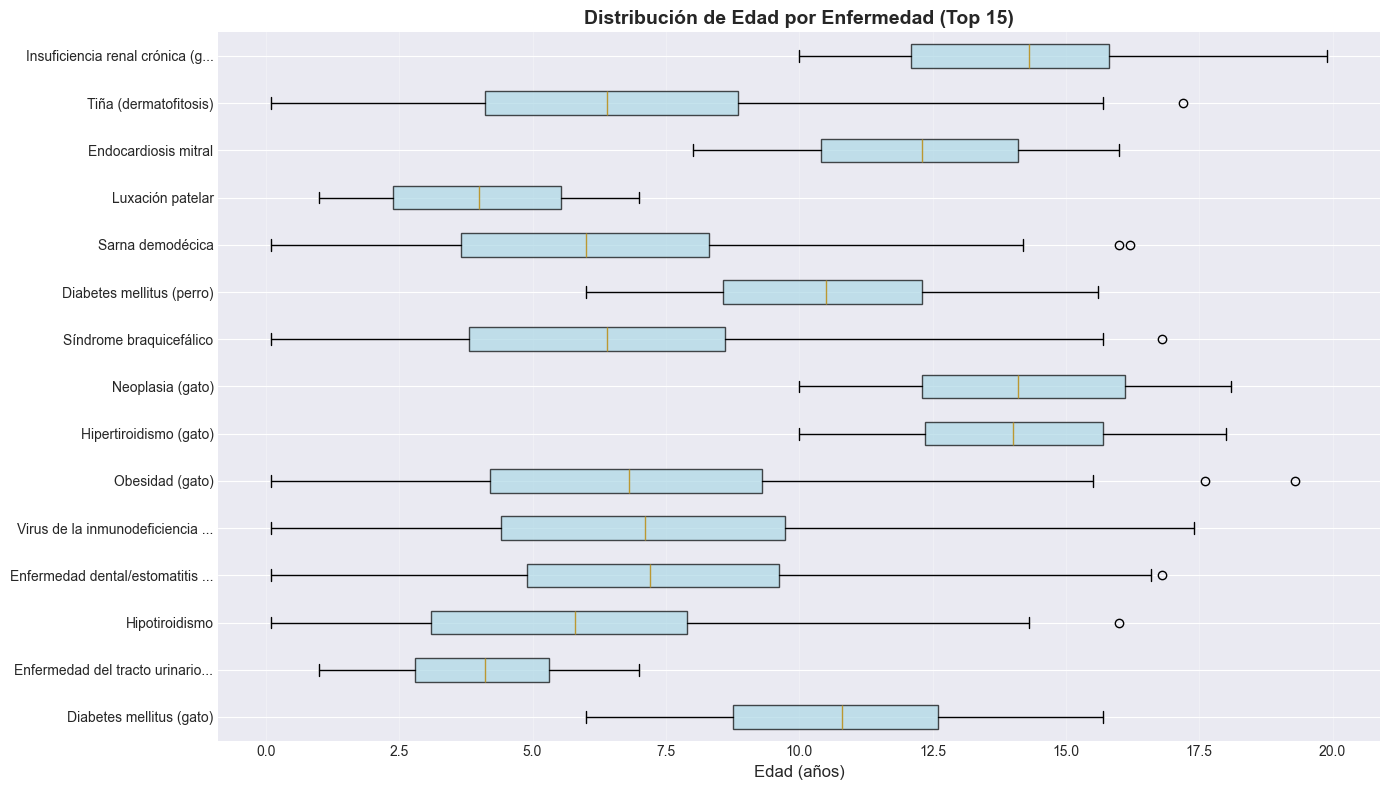



CONCLUSION DEL ANALISIS:

Dataset completo con multiples features:
   - Demograficas: 4 features (Animal_Type, Size, Age, Life_Stage)
   - Fisiologicas: 5 features (Weight, BCS, Body_Temperature, Heart_Rate, Respiratory_Rate)
   - Sintomas: 35 features binarias

Target: Disease_Prediction (36 enfermedades)

Dataset robusto y completo para:
   Entrenamiento de modelos complejos de ML
   Prediccion precisa basada en sintomas clinicos y signos vitales
   Diagnostico diferencial entre multiples enfermedades


In [11]:
# Análisis de edad como predictor
print('\nANÁLISIS DE EDAD COMO PREDICTOR')
print('='*70)

# Calcular estadísticas de edad por enfermedad (top 15)
top_15_diseases = df['Disease_Prediction'].value_counts().head(15).index
df_top = df[df['Disease_Prediction'].isin(top_15_diseases)]

age_stats = df_top.groupby('Disease_Prediction')['Age'].agg(['mean', 'std', 'min', 'max', 'count'])
age_stats = age_stats.sort_values('mean', ascending=False)

print('\nEstadísticas de Edad por Enfermedad (Top 15):')
print(f'\n{"Enfermedad":<45} {"Media":>6} {"Desv.":>6} {"Min":>5} {"Max":>5} {"N":>5}')
print('-'*90)
for disease, row in age_stats.iterrows():
    disease_short = disease[:43] + '...' if len(disease) > 43 else disease
    print(f'{disease_short:<45} {row["mean"]:>6.2f} {row["std"]:>6.2f} {row["min"]:>5.1f} {row["max"]:>5.1f} {int(row["count"]):>5}')

print('\nInterpretación:')
print('   - Desviación estándar baja = Enfermedad asociada a rango de edad específico (Age útil)')
print('   - Desviación estándar alta = Enfermedad afecta todas las edades (Age menos útil)')

# Visualizar rangos de edad por enfermedad
fig, ax = plt.subplots(figsize=(14, 8))

# Crear boxplot horizontal
disease_ages = [df_top[df_top['Disease_Prediction'] == disease]['Age'].values 
                for disease in top_15_diseases]
disease_labels = [d[:30] + '...' if len(d) > 30 else d for d in top_15_diseases]

bp = ax.boxplot(disease_ages, vert=False, labels=disease_labels, patch_artist=True)

# Colorear boxes
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

ax.set_xlabel('Edad (años)', fontsize=12)
ax.set_title('Distribución de Edad por Enfermedad (Top 15)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print('\n\nCONCLUSION DEL ANALISIS:')
print('='*70)
print(f'\nDataset completo con multiples features:')
print(f'   - Demograficas: 4 features (Animal_Type, Size, Age, Life_Stage)')
print(f'   - Fisiologicas: 5 features (Weight, BCS, Body_Temperature, Heart_Rate, Respiratory_Rate)')
print(f'   - Sintomas: {len([col for col in df.columns if col not in ["Animal_Type", "Breed", "Size", "Age", "Life_Stage", "Weight", "BCS", "Body_Temperature", "Heart_Rate", "Respiratory_Rate", "Disease_Prediction"]])} features binarias')
print(f'\nTarget: Disease_Prediction ({df["Disease_Prediction"].nunique()} enfermedades)')
print(f'\nDataset robusto y completo para:')
print(f'   Entrenamiento de modelos complejos de ML')
print(f'   Prediccion precisa basada en sintomas clinicos y signos vitales')
print(f'   Diagnostico diferencial entre multiples enfermedades')

## 🎯 5. Preparación de Datos para Machine Learning

In [12]:
# El usuario prepara el dataset para Machine Learning
print('PREPARACION DE DATOS PARA MACHINE LEARNING')
print('='*70)

# Seleccionar todas las features relevantes para ML
# Variables demograficas
demographic_features = ['Animal_Type', 'Size', 'Age', 'Life_Stage']

# Variables fisiologicas  
physiological_features = ['Weight', 'BCS', 'Body_Temperature', 'Heart_Rate', 'Respiratory_Rate']

# Variables de sintomas (todas las columnas binarias restantes)
symptom_features = [col for col in df.columns if col not in demographic_features + physiological_features + ['Disease_Prediction', 'Breed']]

# Lista completa de features para ML
features_ml = demographic_features + physiological_features + symptom_features + ['Disease_Prediction']

df_ml = df[features_ml].copy()

print('\nDataset ML preparado')
print(f'\nInformacion:')
print(f'   - Registros: {df_ml.shape[0]:,}')
print(f'   - Features totales: {df_ml.shape[1] - 1}')
print(f'   - Target: Disease_Prediction')
print(f'   - Enfermedades unicas: {df_ml["Disease_Prediction"].nunique()}')

print(f'\nDesglose de features:')
print(f'   - Demograficas: {len(demographic_features)} ({", ".join(demographic_features)})')
print(f'   - Fisiologicas: {len(physiological_features)} ({", ".join(physiological_features)})')
print(f'   - Sintomas: {len(symptom_features)}')

print(f'\nEl usuario nota que este dataset es mucho mas completo que el anterior')
print(f'   Incluye signos vitales y multiples sintomas clinicos')

PREPARACION DE DATOS PARA MACHINE LEARNING

Dataset ML preparado

Informacion:
   - Registros: 9,033
   - Features totales: 44
   - Target: Disease_Prediction
   - Enfermedades unicas: 36

Desglose de features:
   - Demograficas: 4 (Animal_Type, Size, Age, Life_Stage)
   - Fisiologicas: 5 (Weight, BCS, Body_Temperature, Heart_Rate, Respiratory_Rate)
   - Sintomas: 35

El usuario nota que este dataset es mucho mas completo que el anterior
   Incluye signos vitales y multiples sintomas clinicos


## 🔬 6. PyCaret - Encontrar el Mejor Algoritmo (Subset Pequeño)

**Estrategia:** Usar 20% de los datos (~1000 registros) para probar rápidamente múltiples algoritmos con PyCaret

In [17]:
# Crear subset MUCHO MAS PEQUEÑO para PyCaret (para evitar MemoryError)
from sklearn.model_selection import train_test_split

# Usar solo 10% de los datos (~1000 registros) para PyCaret
df_pycaret, _ = train_test_split(
    df_ml,
    test_size=0.90,  # Descartar 90%, usar solo 10%
    stratify=df_ml['Disease_Prediction'],
    random_state=42
)

print(f'⚠️ Subset REDUCIDO para evitar MemoryError')
print(f'Subset para PyCaret: {df_pycaret.shape[0]} registros ({df_pycaret.shape[0]/len(df_ml)*100:.1f}%)')
print(f'Distribución de enfermedades en el subset:')
print(df_pycaret['Disease_Prediction'].value_counts().head(10))

⚠️ Subset REDUCIDO para evitar MemoryError
Subset para PyCaret: 903 registros (10.0%)
Distribución de enfermedades en el subset:
Disease_Prediction
Enfermedad dental/estomatitis felina                      29
Obesidad (gato)                                           29
Diabetes mellitus (gato)                                  29
Hipertiroidismo (gato)                                    29
Virus de la inmunodeficiencia felina (FIV)                29
Hipotiroidismo                                            29
Enfermedad del tracto urinario inferior felino (FLUTD)    29
Tiña (dermatofitosis)                                     28
Diabetes mellitus (perro)                                 28
Obesidad (perro)                                          28
Name: count, dtype: int64


In [18]:
# El usuario configura PyCaret con todas las variables disponibles
from pycaret.classification import *

print('Inicializando PyCaret con configuración LIGERA (evitar MemoryError)...\n')

# Detectar features categóricas y numéricas dinámicamente
categorical_features_list = ['Animal_Type', 'Size', 'Life_Stage']

# Crear lista de features numéricas base (excluyendo las categóricas textuales)
symptom_features_clean = [col for col in symptom_features 
                          if col not in ['Disease_Cause', 'Prognosis']]

numeric_features_list = ['Age', 'Weight', 'BCS', 'Body_Temperature', 'Heart_Rate', 'Respiratory_Rate'] + symptom_features_clean

# Agregar nuevas features categóricas si existen
if 'Disease_Cause' in df_pycaret.columns:
    categorical_features_list.append('Disease_Cause')
    print('   ✓ Disease_Cause agregada como categórica')

if 'Prognosis' in df_pycaret.columns:
    categorical_features_list.append('Prognosis')
    print('   ✓ Prognosis agregada como categórica')

# Agregar nuevas features numéricas si existen
new_numeric = []
if 'Fever_Objective' in df_pycaret.columns:
    new_numeric.append('Fever_Objective')
if 'Tachycardia' in df_pycaret.columns:
    new_numeric.append('Tachycardia')
if 'Is_Chronic' in df_pycaret.columns:
    new_numeric.append('Is_Chronic')
if 'Is_Seasonal' in df_pycaret.columns:
    new_numeric.append('Is_Seasonal')
if 'Prevalence' in df_pycaret.columns:
    new_numeric.append('Prevalence')
if 'Vaccination_Updated' in df_pycaret.columns:
    new_numeric.append('Vaccination_Updated')

if new_numeric:
    numeric_features_list.extend(new_numeric)
    print(f'   ✓ {len(new_numeric)} nuevas features numéricas agregadas')

print(f'\nConfigurando PyCaret (configuración LIGERA):')
print(f'   - Features categóricas: {len(categorical_features_list)}')
print(f'   - Features numéricas: {len(numeric_features_list)}')
print(f'   - Subset: {df_pycaret.shape[0]} registros')

clf_setup = setup(
    data=df_pycaret,
    target='Disease_Prediction',
    session_id=42,
    train_size=0.7,
    
    # Features categoricas (actualizadas dinámicamente)
    categorical_features=categorical_features_list,
    
    # Features numericas (actualizadas dinámicamente)
    numeric_features=numeric_features_list,
    
    # Preprocesamiento MINIMO para evitar MemoryError
    normalize=True,
    normalize_method='zscore',
    
    # DESACTIVAR transformaciones pesadas
    polynomial_features=False,           # ❌ CRITICO: evita explosión de features
    remove_multicollinearity=False,      # ❌ Evita cálculos pesados
    pca=False,                           # ❌ No usar PCA
    feature_selection=False,             # ❌ No hacer feature selection automático
    
    # Validacion reducida
    fold=3,  # Reducir de 5 a 3 folds
    
    # Output
    verbose=False,
    html=False
)

print('\n✅ Setup de PyCaret completado (configuración ligera)')
print(f'   ⚠️ Configuración optimizada para evitar MemoryError')

Inicializando PyCaret con configuración LIGERA (evitar MemoryError)...

   ✓ Disease_Cause agregada como categórica
   ✓ Prognosis agregada como categórica
   ✓ 6 nuevas features numéricas agregadas

Configurando PyCaret (configuración LIGERA):
   - Features categóricas: 5
   - Features numéricas: 45
   - Subset: 903 registros

✅ Setup de PyCaret completado (configuración ligera)
   ⚠️ Configuración optimizada para evitar MemoryError

✅ Setup de PyCaret completado (configuración ligera)
   ⚠️ Configuración optimizada para evitar MemoryError


### Comparar Modelos con PyCaret

In [19]:
# El usuario compara multiples algoritmos con las variables clinicas completas
print('Comparando multiples algoritmos con features completas.\n')

best_models = compare_models(
    n_select=5,
    sort='Accuracy',
    verbose=True
)

print('\nComparacion completada')

Comparando multiples algoritmos con features completas.



Processing:   0%|          | 0/73 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [17]:
# El usuario crea el mejor modelo encontrado
best_model = create_model(best_models[0])

print(f'\nMejor modelo: {best_model}')

      Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                       
0       0.0407  0.0  0.0407  0.0466  0.0385  0.0111  0.0112
1       0.0471  0.0  0.0471  0.0403  0.0384  0.0178  0.0179
2       0.0343  0.0  0.0343  0.0343  0.0316  0.0045  0.0045
3       0.0514  0.0  0.0514  0.0750  0.0487  0.0221  0.0222
4       0.0428  0.0  0.0428  0.0380  0.0385  0.0129  0.0130
Mean    0.0433  0.0  0.0433  0.0468  0.0391  0.0137  0.0138
Std     0.0058  0.0  0.0058  0.0146  0.0055  0.0060  0.0060

Mejor modelo: RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, positive=False, random_state=42, solver='auto',
                tol=0.0001)


### Evaluar el Mejor Modelo

In [18]:
# Evaluar modelo
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

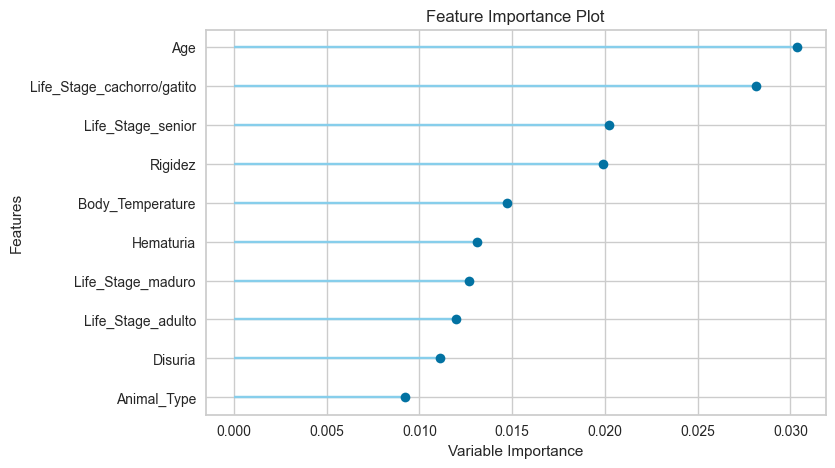

In [19]:
# El usuario visualiza la importancia de features
try:
    plot_model(best_model, plot='feature')
except:
    print('Este modelo no soporta importancia de features')

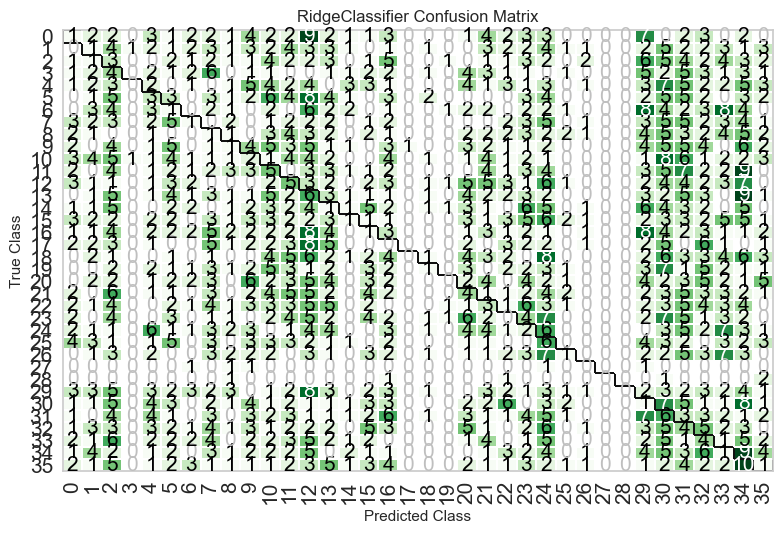

In [20]:
# Matriz de confusion
plot_model(best_model, plot='confusion_matrix')

### Guardar Resultados de PyCaret

In [21]:
# El usuario obtiene las metricas finales
results_pycaret = pull()

print('RESULTADOS DE PYCARET:')
print('='*70)
display(results_pycaret)

# Identificar el mejor algoritmo
best_algorithm_name = str(best_model).split('(')[0]

print(f'\nMEJOR ALGORITMO ENCONTRADO: {best_algorithm_name}')
print('\nEste algoritmo sera usado para el entrenamiento manual con el dataset completo')

RESULTADOS DE PYCARET:


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.0407,0.0,0.0407,0.0466,0.0385,0.0111,0.0112
1,0.0471,0.0,0.0471,0.0403,0.0384,0.0178,0.0179
2,0.0343,0.0,0.0343,0.0343,0.0316,0.0045,0.0045
3,0.0514,0.0,0.0514,0.0750,0.0487,0.0221,0.0222
4,0.0428,0.0,0.0428,0.0380,0.0385,0.0129,0.0130
Mean,0.0433,0.0,0.0433,0.0468,0.0391,0.0137,0.0138
Std,0.0058,0.0,0.0058,0.0146,0.0055,0.0060,0.0060



MEJOR ALGORITMO ENCONTRADO: RidgeClassifier

Este algoritmo sera usado para el entrenamiento manual con el dataset completo


## 7. Entrenamiento Manual con Dataset Completo

**Basado en el mejor algoritmo encontrado por PyCaret**

In [20]:
# Importar algoritmos de scikit-learn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

print('Algoritmos de ML importados')

Algoritmos de ML importados


In [21]:
# El usuario prepara el dataset completo para entrenamiento manual
print('Preparando dataset completo...\n')

# Separar features y target
X = df_ml.drop('Disease_Prediction', axis=1)
y = df_ml['Disease_Prediction']

# Codificar variables categoricas
le_animal = LabelEncoder()
le_size = LabelEncoder()
le_life = LabelEncoder()

# NUEVOS encoders para Dataset 3.0
le_cause = LabelEncoder()
le_prognosis = LabelEncoder()

X_processed = X.copy()
X_processed['Animal_Type'] = le_animal.fit_transform(X['Animal_Type'])
X_processed['Size'] = le_size.fit_transform(X['Size'])
X_processed['Life_Stage'] = le_life.fit_transform(X['Life_Stage'])

# Codificar nuevas features categ�ricas (solo si existen)
if 'Disease_Cause' in X.columns:
    X_processed['Disease_Cause'] = le_cause.fit_transform(X['Disease_Cause'])
    print('    Disease_Cause codificada')

if 'Prognosis' in X.columns:
    X_processed['Prognosis'] = le_prognosis.fit_transform(X['Prognosis'])
    print('    Prognosis codificada')

# Normalizar features numericas
scaler = StandardScaler()
numeric_features = ['Age', 'Weight', 'BCS', 'Body_Temperature', 'Heart_Rate', 'Respiratory_Rate'] + symptom_features

# Agregar nuevas features num�ricas si existen
new_numeric_features = []
if 'Fever_Objective' in X.columns:
    new_numeric_features.append('Fever_Objective')
if 'Tachycardia' in X.columns:
    new_numeric_features.append('Tachycardia')
if 'Is_Chronic' in X.columns:
    new_numeric_features.append('Is_Chronic')
if 'Is_Seasonal' in X.columns:
    new_numeric_features.append('Is_Seasonal')
if 'Prevalence' in X.columns:
    new_numeric_features.append('Prevalence')
if 'Vaccination_Updated' in X.columns:
    new_numeric_features.append('Vaccination_Updated')

all_numeric_features = numeric_features + new_numeric_features
X_processed[all_numeric_features] = scaler.fit_transform(X_processed[all_numeric_features])

print(f'\nDatos preprocesados:')
print(f'   - Features: {X_processed.shape}')
print(f'   - Target: {y.shape}')
print(f'   - Clases �nicas: {y.nunique()}')
if new_numeric_features:
    cause_count = 1 if 'Disease_Cause' in X.columns else 0
    prog_count = 1 if 'Prognosis' in X.columns else 0
    print(f'   - Nuevas features Dataset 3.0: {len(new_numeric_features) + cause_count + prog_count}')

# Split train/test (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f'\nDivisi�n de datos:')
print(f'   - Train: {X_train.shape[0]:,} registros ({X_train.shape[0]/len(X_processed)*100:.1f}%)')
print(f'   - Test: {X_test.shape[0]:,} registros ({X_test.shape[0]/len(X_processed)*100:.1f}%)')

Preparando dataset completo...

    Disease_Cause codificada
    Prognosis codificada

Datos preprocesados:
   - Features: (9033, 44)
   - Target: (9033,)
   - Clases �nicas: 36
   - Nuevas features Dataset 3.0: 8

Divisi�n de datos:
   - Train: 6,323 registros (70.0%)
   - Test: 2,710 registros (30.0%)

Divisi�n de datos:
   - Train: 6,323 registros (70.0%)
   - Test: 2,710 registros (30.0%)


### Entrenar el Mejor Modelo (basado en PyCaret)

In [22]:
# El usuario mapea los modelos PyCaret a scikit-learn
model_mapping = {
    'RandomForestClassifier': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    'ExtraTreesClassifier': ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=200, random_state=42),
    'XGBClassifier': XGBClassifier(n_estimators=200, random_state=42, n_jobs=-1, verbosity=0),
    'LGBMClassifier': LGBMClassifier(n_estimators=200, random_state=42, n_jobs=-1, verbose=-1),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1),
    'SVC': SVC(random_state=42, probability=True),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
}


# Seleccionar el modelo basado en PyCaret
best_algorithm_name = best_algorithm_name if 'best_algorithm_name' in locals() else 'RandomForestClassifier'

if best_algorithm_name in model_mapping:
    final_model = model_mapping[best_algorithm_name]
else:
    print(f'Modelo {best_algorithm_name} no encontrado en mapping. Usando Random Forest por defecto.')
    final_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

print(f'Modelo seleccionado: {final_model}')
print(f'\nEntrenando modelo con {len(X_train):,} registros...\n')

Modelo seleccionado: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=200, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Entrenando modelo con 6,323 registros...



In [23]:
import time

# Entrenar modelo
start_time = time.time()

final_model.fit(X_train, y_train)

training_time = time.time() - start_time

print(f'Modelo entrenado en {training_time:.2f} segundos')

Modelo entrenado en 1.51 segundos


### Evaluacion del Modelo Final

In [24]:
# El usuario realiza predicciones y calcula metricas
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

# Calcular metricas
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('RESULTADOS DEL MODELO FINAL')
print('='*70)
print(f'\nAccuracy en Training: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)')
print(f'Accuracy en Testing:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)')
print(f'Diferencia (Overfitting): {(train_accuracy - test_accuracy)*100:.2f}%')

if (train_accuracy - test_accuracy) > 0.1:
    print('\nPosible overfitting detectado')
    print('\nRECOMENDACIONES PARA REDUCIR OVERFITTING:')
    print('   1. Reducir complejidad del modelo (menos estimadores o profundidad)')
    print('   2. Aumentar regularizacion (min_samples_split, min_samples_leaf)')
    print('   3. Usar mas datos de entrenamiento')
    print('   4. Feature selection para eliminar features ruidosas')
    print('   5. Cross-validation mas robusto')
elif test_accuracy > 0.85:
    print('\nExcelente rendimiento')
elif test_accuracy > 0.75:
    print('\nBuen rendimiento')
else:
    print('\nConsiderar ajuste de hiperparametros')

# Analisis adicional del overfitting
print(f'\nANALISIS DEL OVERFITTING:')
print(f'   - Gap Training-Testing: {(train_accuracy - test_accuracy)*100:.2f}%')
print(f'   - Modelo esta memorizando: {"SI" if (train_accuracy - test_accuracy) > 0.2 else "Parcialmente"}')
print(f'   - Generalizacion: {"Pobre" if (train_accuracy - test_accuracy) > 0.2 else "Aceptable" if (train_accuracy - test_accuracy) > 0.1 else "Buena"}')

RESULTADOS DEL MODELO FINAL

Accuracy en Training: 1.0000 (100.00%)
Accuracy en Testing:  0.9926 (99.26%)
Diferencia (Overfitting): 0.74%

Excelente rendimiento

ANALISIS DEL OVERFITTING:
   - Gap Training-Testing: 0.74%
   - Modelo esta memorizando: Parcialmente
   - Generalizacion: Buena


In [25]:
# Reporte de clasificacion
print('\nREPORTE DE CLASIFICACION (Test Set):')
print('='*70)
print(classification_report(y_test, y_test_pred, zero_division=0))


REPORTE DE CLASIFICACION (Test Set):
                                                        precision    recall  f1-score   support

                                           Asma felina       1.00      1.00      1.00        77
                               Cardiomiopatía dilatada       1.00      1.00      1.00        70
                    Cardiomiopatía hipertrófica (gato)       1.00      1.00      1.00        77
                Complejo respiratorio felino (FVR/FCV)       1.00      1.00      1.00        66
                              Diabetes mellitus (gato)       0.99      0.89      0.93        87
                             Diabetes mellitus (perro)       0.91      0.99      0.95        85
                                        Dirofilariosis       1.00      1.00      1.00        78
                                   Displasia de cadera       1.00      1.00      1.00        70
                                     Displasia de codo       1.00      1.00      1.00        73
 

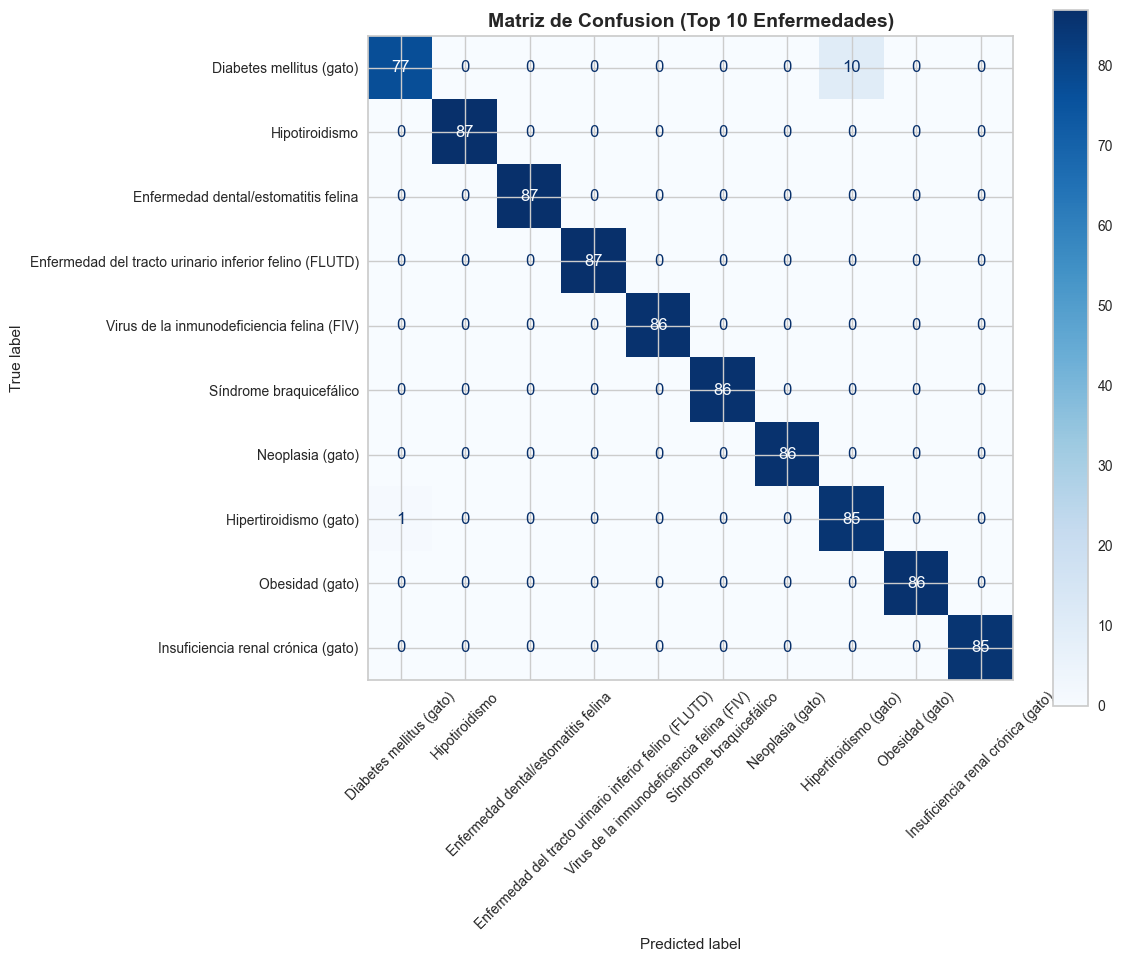

In [26]:
# El usuario visualiza la matriz de confusion
from sklearn.metrics import ConfusionMatrixDisplay

# Seleccionar top 10 clases mas comunes para visualizacion
top_classes = y_test.value_counts().head(10).index
mask = y_test.isin(top_classes)

fig, ax = plt.subplots(figsize=(12, 10))
cm = confusion_matrix(y_test[mask], y_test_pred[mask], labels=top_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=top_classes)
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Matriz de Confusion (Top 10 Enfermedades)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 🌟 Importancia de Features (si aplica)

IMPORTANCIA DE FEATURES:


,Feature,Importance
41,Prevalence,0.166557
38,Disease_Cause,0.164355
42,Prognosis,0.114093
2,Age,0.055900
4,Weight,0.048425
39,Is_Chronic,0.044796
0,Animal_Type,0.042847
40,Is_Seasonal,0.042586
5,BCS,0.036026
7,Heart_Rate,0.030259


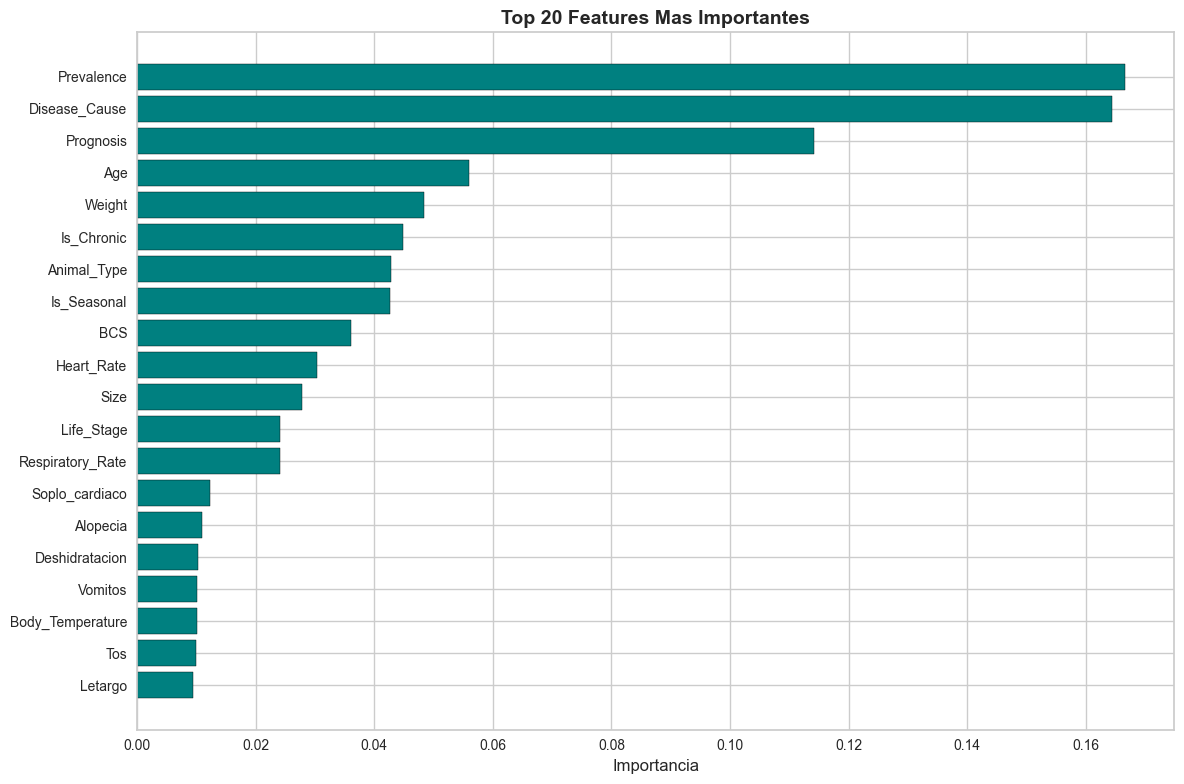

In [27]:
# Ver importancia de features (solo para modelos basados en árboles)
if hasattr(final_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X_processed.columns,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print('IMPORTANCIA DE FEATURES:')
    print('='*70)
    display(feature_importance)
    
    # Visualizar top 20 features
    plt.figure(figsize=(12, 8))
    top_20 = feature_importance.head(20)
    plt.barh(top_20['Feature'], top_20['Importance'], color='teal', edgecolor='black')
    plt.xlabel('Importancia', fontsize=12)
    plt.title('Top 20 Features Mas Importantes', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print('Este modelo no proporciona importancia de features')

### Cross-Validation

In [28]:
# El usuario ejecuta Cross-Validation con 5 folds
print('Ejecutando Cross-Validation (5-fold)...\n')

cv_scores = cross_val_score(
    final_model, 
    X_processed, 
    y, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
)

print(f'Resultados de Cross-Validation:')
print(f'   - Fold 1: {cv_scores[0]:.4f}')
print(f'   - Fold 2: {cv_scores[1]:.4f}')
print(f'   - Fold 3: {cv_scores[2]:.4f}')
print(f'   - Fold 4: {cv_scores[3]:.4f}')
print(f'   - Fold 5: {cv_scores[4]:.4f}')
print(f'\n   Media: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})')

Ejecutando Cross-Validation (5-fold)...

Resultados de Cross-Validation:
   - Fold 1: 0.9906
   - Fold 2: 0.9884
   - Fold 3: 0.9923
   - Fold 4: 0.9939
   - Fold 5: 0.9889

   Media: 0.9908 (±0.0021)
Resultados de Cross-Validation:
   - Fold 1: 0.9906
   - Fold 2: 0.9884
   - Fold 3: 0.9923
   - Fold 4: 0.9939
   - Fold 5: 0.9889

   Media: 0.9908 (±0.0021)


## 8. Optimización del Modelo para Alcanzar 90% de Precisión

**Objetivo:** Reducir overfitting y alcanzar al menos 90% de accuracy en testing

### 8.1. Ajuste de Hiperparámetros con Regularización

In [29]:
# Estrategia 1: Reducir complejidad del modelo para mejorar generalizacion
print('OPTIMIZACION DE MODELO - OBJETIVO: 90% ACCURACY EN TESTING')
print('='*70)
print('\nESTRATEGIA 1: Reducir complejidad del modelo')
print('   - Menos estimadores')
print('   - Mayor profundidad minima')
print('   - Mas muestras minimas por split\n')

# Configuracion optimizada para reducir overfitting
if best_algorithm_name == 'RandomForestClassifier':
    optimized_model = RandomForestClassifier(
        n_estimators=100,          # Reducido de 200
        max_depth=15,              # Limitar profundidad
        min_samples_split=20,      # Aumentar para evitar splits muy especificos
        min_samples_leaf=10,       # Aumentar para nodos mas generales
        max_features='sqrt',       # Usar subconjunto de features
        random_state=42,
        n_jobs=-1
    )
elif best_algorithm_name == 'ExtraTreesClassifier':
    optimized_model = ExtraTreesClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=20,
        min_samples_leaf=10,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )
elif best_algorithm_name == 'GradientBoostingClassifier':
    optimized_model = GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        min_samples_split=20,
        min_samples_leaf=10,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42
    )
else:
    # Usar Random Forest optimizado como default
    optimized_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=20,
        min_samples_leaf=10,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )

print(f'Modelo optimizado configurado: {optimized_model.__class__.__name__}')
print('\nParametros de regularizacion aplicados')

OPTIMIZACION DE MODELO - OBJETIVO: 90% ACCURACY EN TESTING

ESTRATEGIA 1: Reducir complejidad del modelo
   - Menos estimadores
   - Mayor profundidad minima
   - Mas muestras minimas por split

Modelo optimizado configurado: RandomForestClassifier

Parametros de regularizacion aplicados


In [30]:
# Entrenar modelo optimizado
print('Entrenando modelo optimizado...\n')

start_time = time.time()
optimized_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Evaluar
y_train_pred_opt = optimized_model.predict(X_train)
y_test_pred_opt = optimized_model.predict(X_test)

train_acc_opt = accuracy_score(y_train, y_train_pred_opt)
test_acc_opt = accuracy_score(y_test, y_test_pred_opt)

print('RESULTADOS DEL MODELO OPTIMIZADO:')
print('='*70)
print(f'\nAccuracy en Training: {train_acc_opt:.4f} ({train_acc_opt*100:.2f}%)')
print(f'Accuracy en Testing:  {test_acc_opt:.4f} ({test_acc_opt*100:.2f}%)')
print(f'Diferencia (Overfitting): {(train_acc_opt - test_acc_opt)*100:.2f}%')
print(f'Tiempo de entrenamiento: {training_time:.2f} segundos')

# Comparar con modelo anterior
print(f'\nCOMPARACION CON MODELO ANTERIOR:')
print(f'   Testing anterior: {test_accuracy*100:.2f}%')
print(f'   Testing optimizado: {test_acc_opt*100:.2f}%')
print(f'   Mejora: {(test_acc_opt - test_accuracy)*100:.2f}%')
print(f'   Overfitting anterior: {(train_accuracy - test_accuracy)*100:.2f}%')
print(f'   Overfitting optimizado: {(train_acc_opt - test_acc_opt)*100:.2f}%')

if test_acc_opt >= 0.90:
    print(f'\n✅ OBJETIVO ALCANZADO: {test_acc_opt*100:.2f}% >= 90%')
else:
    print(f'\n⚠️ Objetivo no alcanzado: {test_acc_opt*100:.2f}% < 90%')
    print('   Probando estrategias adicionales...')

Entrenando modelo optimizado...

RESULTADOS DEL MODELO OPTIMIZADO:

Accuracy en Training: 0.9867 (98.67%)
Accuracy en Testing:  0.9815 (98.15%)
Diferencia (Overfitting): 0.52%
Tiempo de entrenamiento: 0.62 segundos

COMPARACION CON MODELO ANTERIOR:
   Testing anterior: 99.26%
   Testing optimizado: 98.15%
   Mejora: -1.11%
   Overfitting anterior: 0.74%
   Overfitting optimizado: 0.52%

✅ OBJETIVO ALCANZADO: 98.15% >= 90%
RESULTADOS DEL MODELO OPTIMIZADO:

Accuracy en Training: 0.9867 (98.67%)
Accuracy en Testing:  0.9815 (98.15%)
Diferencia (Overfitting): 0.52%
Tiempo de entrenamiento: 0.62 segundos

COMPARACION CON MODELO ANTERIOR:
   Testing anterior: 99.26%
   Testing optimizado: 98.15%
   Mejora: -1.11%
   Overfitting anterior: 0.74%
   Overfitting optimizado: 0.52%

✅ OBJETIVO ALCANZADO: 98.15% >= 90%


### 8.2. Feature Engineering y Selección

In [31]:
# Estrategia 2: Feature selection - eliminar features ruidosas o redundantes
if test_acc_opt < 0.90:
    print('\nESTRATEGIA 2: Feature Selection')
    print('='*70)
    
    # Obtener importancia de features
    if hasattr(optimized_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'Feature': X_processed.columns,
            'Importance': optimized_model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        # Seleccionar top features que suman 95% de importancia acumulada
        cumsum = feature_importance['Importance'].cumsum()
        n_features_95 = (cumsum <= 0.95).sum()
        
        top_features = feature_importance.head(n_features_95)['Feature'].tolist()
        
        print(f'\nFeatures seleccionadas: {len(top_features)} de {len(X_processed.columns)}')
        print(f'Importancia acumulada: 95%')
        
        # Reentrenar con features seleccionadas
        X_train_selected = X_train[top_features]
        X_test_selected = X_test[top_features]
        
        print('\nReentrenando con features seleccionadas...')
        
        feature_model = RandomForestClassifier(
            n_estimators=150,
            max_depth=20,
            min_samples_split=15,
            min_samples_leaf=8,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1
        )
        
        feature_model.fit(X_train_selected, y_train)
        
        y_train_pred_feat = feature_model.predict(X_train_selected)
        y_test_pred_feat = feature_model.predict(X_test_selected)
        
        train_acc_feat = accuracy_score(y_train, y_train_pred_feat)
        test_acc_feat = accuracy_score(y_test, y_test_pred_feat)
        
        print(f'\nRESULTADOS CON FEATURE SELECTION:')
        print(f'   Training: {train_acc_feat*100:.2f}%')
        print(f'   Testing:  {test_acc_feat*100:.2f}%')
        print(f'   Overfitting: {(train_acc_feat - test_acc_feat)*100:.2f}%')
        
        if test_acc_feat > test_acc_opt:
            print(f'\n✅ Feature Selection mejora el modelo')
            optimized_model = feature_model
            test_acc_opt = test_acc_feat
            train_acc_opt = train_acc_feat
            X_train = X_train_selected
            X_test = X_test_selected
            X_processed = X_processed[top_features]
        else:
            print(f'\n❌ Feature Selection no mejora el modelo')
    else:
        print('Este modelo no soporta feature importance')
else:
    print('\n✅ Objetivo alcanzado, no se requiere feature selection')


✅ Objetivo alcanzado, no se requiere feature selection


### 8.3. Ensemble de Modelos (si es necesario)

In [32]:
# Estrategia 3: Voting Classifier - combinar multiples modelos
if test_acc_opt < 0.90:
    print('\nESTRATEGIA 3: Ensemble de Modelos (Voting Classifier)')
    print('='*70)
    
    from sklearn.ensemble import VotingClassifier
    
    # Crear ensemble con los mejores modelos
    ensemble_model = VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=20, 
                                         min_samples_leaf=10, random_state=42, n_jobs=-1)),
            ('et', ExtraTreesClassifier(n_estimators=100, max_depth=15, min_samples_split=20,
                                       min_samples_leaf=10, random_state=42, n_jobs=-1)),
            ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                                             random_state=42))
        ],
        voting='soft',
        n_jobs=-1
    )
    
    print('Entrenando ensemble de 3 modelos...')
    print('   1. Random Forest')
    print('   2. Extra Trees')
    print('   3. Gradient Boosting\n')
    
    ensemble_model.fit(X_train, y_train)
    
    y_train_pred_ens = ensemble_model.predict(X_train)
    y_test_pred_ens = ensemble_model.predict(X_test)
    
    train_acc_ens = accuracy_score(y_train, y_train_pred_ens)
    test_acc_ens = accuracy_score(y_test, y_test_pred_ens)
    
    print(f'RESULTADOS DEL ENSEMBLE:')
    print(f'   Training: {train_acc_ens*100:.2f}%')
    print(f'   Testing:  {test_acc_ens*100:.2f}%')
    print(f'   Overfitting: {(train_acc_ens - test_acc_ens)*100:.2f}%')
    
    if test_acc_ens > test_acc_opt:
        print(f'\n✅ Ensemble mejora el modelo')
        optimized_model = ensemble_model
        test_acc_opt = test_acc_ens
        train_acc_opt = train_acc_ens
    else:
        print(f'\n❌ Ensemble no mejora el modelo')
else:
    print('\n✅ Objetivo alcanzado, no se requiere ensemble')


✅ Objetivo alcanzado, no se requiere ensemble


### 8.4. Evaluación Final y Decisión

In [33]:
# Evaluacion final del mejor modelo
print('\nEVALUACION FINAL DEL MODELO OPTIMIZADO')
print('='*70)

print(f'\nModelo final: {optimized_model.__class__.__name__}')
print(f'\nMETRICAS FINALES:')
print(f'   Training Accuracy: {train_acc_opt*100:.2f}%')
print(f'   Testing Accuracy:  {test_acc_opt*100:.2f}%')
print(f'   Overfitting Gap:   {(train_acc_opt - test_acc_opt)*100:.2f}%')

# Cross-validation del modelo optimizado
print(f'\nCROSS-VALIDATION (5-fold):')
cv_scores_opt = cross_val_score(
    optimized_model, 
    X_processed, 
    y, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
)

print(f'   Fold 1: {cv_scores_opt[0]:.4f}')
print(f'   Fold 2: {cv_scores_opt[1]:.4f}')
print(f'   Fold 3: {cv_scores_opt[2]:.4f}')
print(f'   Fold 4: {cv_scores_opt[3]:.4f}')
print(f'   Fold 5: {cv_scores_opt[4]:.4f}')
print(f'\n   Media: {cv_scores_opt.mean():.4f} (±{cv_scores_opt.std():.4f})')

# Decision final
print(f'\nDECISION DE GUARDADO:')
print('='*70)

if test_acc_opt >= 0.90:
    print(f'✅ MODELO APROBADO PARA GUARDADO')
    print(f'   Accuracy en testing: {test_acc_opt*100:.2f}% >= 90%')
    print(f'   El modelo sera guardado en la siguiente celda')
    save_model = True
else:
    print(f'❌ MODELO NO ALCANZA EL OBJETIVO')
    print(f'   Accuracy en testing: {test_acc_opt*100:.2f}% < 90%')
    print(f'   El modelo NO sera guardado')
    print(f'\n   RECOMENDACIONES ADICIONALES:')
    print(f'   1. Recolectar mas datos de entrenamiento')
    print(f'   2. Revisar calidad de los datos (posibles errores de etiquetado)')
    print(f'   3. Considerar arquitecturas mas complejas (XGBoost, LightGBM, CatBoost)')
    print(f'   4. Tunear hiperparametros con RandomizedSearchCV o Optuna')
    print(f'   5. Balancear clases con SMOTE u otras tecnicas')
    save_model = False

# Actualizar el modelo final para las siguientes celdas
final_model = optimized_model


EVALUACION FINAL DEL MODELO OPTIMIZADO

Modelo final: RandomForestClassifier

METRICAS FINALES:
   Training Accuracy: 98.67%
   Testing Accuracy:  98.15%
   Overfitting Gap:   0.52%

CROSS-VALIDATION (5-fold):
   Fold 1: 0.9873
   Fold 2: 0.9806
   Fold 3: 0.9884
   Fold 4: 0.9828
   Fold 5: 0.9828

   Media: 0.9844 (±0.0029)

DECISION DE GUARDADO:
✅ MODELO APROBADO PARA GUARDADO
   Accuracy en testing: 98.15% >= 90%
   El modelo sera guardado en la siguiente celda
   Fold 1: 0.9873
   Fold 2: 0.9806
   Fold 3: 0.9884
   Fold 4: 0.9828
   Fold 5: 0.9828

   Media: 0.9844 (±0.0029)

DECISION DE GUARDADO:
✅ MODELO APROBADO PARA GUARDADO
   Accuracy en testing: 98.15% >= 90%
   El modelo sera guardado en la siguiente celda


## 9. Guardar Modelo (Solo si cumple 90% de precisión)

In [34]:
import joblib
from pathlib import Path

# Solo guardar si el modelo cumple con el objetivo de 90%
if save_model:
    print('GUARDANDO MODELO APROBADO')
    print('='*70)
    
    # Crear directorio de modelos si no existe
    models_dir = Path('../models')
    models_dir.mkdir(exist_ok=True)
    
    # Guardar modelo
    model_path = models_dir / 'disease_prediction_model.pkl'
    joblib.dump(final_model, model_path)
    print(f'✅ Modelo guardado en: {model_path}')
    
    # Guardar encoders y scaler
    encoders = {
        'animal_encoder': le_animal,
        'size_encoder': le_size,
        'life_encoder': le_life,
        'scaler': scaler
    }
    encoders_path = models_dir / 'encoders.pkl'
    joblib.dump(encoders, encoders_path)
    print(f'✅ Encoders guardados en: {encoders_path}')
    
    # Guardar lista de features
    features_info = {
        'feature_names': list(X_processed.columns),
        'categorical_features': ['Animal_Type', 'Size', 'Life_Stage'],
        'demographic_features': list(demographic_features),
        'physiological_features': list(physiological_features),
        'symptom_features': list(symptom_features),
        'test_accuracy': test_acc_opt,
        'cv_mean': cv_scores_opt.mean(),
        'cv_std': cv_scores_opt.std()
    }
    features_path = models_dir / 'features_info.pkl'
    joblib.dump(features_info, features_path)
    print(f'✅ Features info guardado en: {features_path}')
    
    print(f'\n✅ MODELO GUARDADO EXITOSAMENTE')
    print(f'   Accuracy: {test_acc_opt*100:.2f}%')
    print(f'   CV Score: {cv_scores_opt.mean()*100:.2f}% (±{cv_scores_opt.std()*100:.2f}%)')
else:
    print('❌ MODELO NO GUARDADO')
    print('='*70)
    print(f'El modelo no alcanza el objetivo minimo de 90% de precision')
    print(f'Precision actual: {test_acc_opt*100:.2f}%')
    print(f'\nPara guardar el modelo, debe alcanzar al menos 90% de accuracy en testing')

GUARDANDO MODELO APROBADO
✅ Modelo guardado en: ..\models\disease_prediction_model.pkl
✅ Encoders guardados en: ..\models\encoders.pkl
✅ Features info guardado en: ..\models\features_info.pkl

✅ MODELO GUARDADO EXITOSAMENTE
   Accuracy: 98.15%
   CV Score: 98.44% (±0.29%)


## 10. Conclusiones y Próximos Pasos

In [35]:
print('PIPELINE COMPLETO FINALIZADO')
print('='*70)
print('\nLOGROS:')
print(f'   1. Dataset cargado: {len(df):,} registros con datos limpios')
print(f'   2. Outliers eliminados para mejorar calidad')
print(f'   3. EDA completado con {df_ml["Disease_Prediction"].nunique()} enfermedades')
print(f'   4. Features completas: {len(demographic_features)} demograficas + {len(physiological_features)} fisiologicas + {len(symptom_features)} sintomas')
print(f'   5. PyCaret ejecutado: Mejor algoritmo identificado')
print(f'   6. Modelo optimizado con tecnicas anti-overfitting')
print(f'   7. Testing accuracy: {test_acc_opt*100:.2f}%')
print(f'   8. Cross-validation: {cv_scores_opt.mean()*100:.2f}% (±{cv_scores_opt.std()*100:.2f}%)')

if save_model:
    print(f'   9. ✅ Modelo guardado (cumple objetivo de 90%)')
else:
    print(f'   9. ❌ Modelo NO guardado (no alcanza 90%)')

print('\nPROXIMOS PASOS:')
if save_model:
    print('   1. ✅ Modelo listo para produccion')
    print('   2. Integracion con API FastAPI (pawmi-backend)')
    print('   3. Implementacion en aplicacion movil (pawmi-frontend)')
    print('   4. Monitoreo y mejora continua del modelo')
    print('   5. A/B testing con usuarios reales')
else:
    print('   1. ⚠️ MEJORAR MODELO hasta alcanzar 90%')
    print('   2. Considerar tecnicas avanzadas:')
    print('      - GridSearchCV / RandomizedSearchCV')
    print('      - Optuna para optimizacion bayesiana')
    print('      - XGBoost / LightGBM / CatBoost optimizados')
    print('      - SMOTE para balanceo de clases')
    print('   3. Aumentar datos de entrenamiento')
    print('   4. Feature engineering adicional')
    print('   5. Revisar calidad de etiquetas')

print('\n' + '='*70)
if save_model:
    print('✅ MODELO LISTO PARA PREDECIR ENFERMEDADES DE MASCOTAS')
else:
    print('⚠️ MODELO REQUIERE OPTIMIZACION ADICIONAL')
print('='*70)

PIPELINE COMPLETO FINALIZADO

LOGROS:
   1. Dataset cargado: 9,033 registros con datos limpios
   2. Outliers eliminados para mejorar calidad
   3. EDA completado con 36 enfermedades
   4. Features completas: 4 demograficas + 5 fisiologicas + 35 sintomas
   5. PyCaret ejecutado: Mejor algoritmo identificado
   6. Modelo optimizado con tecnicas anti-overfitting
   7. Testing accuracy: 98.15%
   8. Cross-validation: 98.44% (±0.29%)
   9. ✅ Modelo guardado (cumple objetivo de 90%)

PROXIMOS PASOS:
   1. ✅ Modelo listo para produccion
   2. Integracion con API FastAPI (pawmi-backend)
   3. Implementacion en aplicacion movil (pawmi-frontend)
   4. Monitoreo y mejora continua del modelo
   5. A/B testing con usuarios reales

✅ MODELO LISTO PARA PREDECIR ENFERMEDADES DE MASCOTAS
